#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
ls_type = :wls
rotated_param = get_rotated_param(dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
rotated_planar = get_circuit(rotated_param, dep_param)
dist_max = 11
dist_range = collect(3:dist_max)
dense_range = collect(2:0.025:(dist_max+1))
# Load the metadata
metadata_dict = load("data/design_metadata_$(rotated_param.circuit_name).jld2")
@assert rotated_param == metadata_dict["rotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
merit_data_file = jldopen(
    pwd() *
    "/data/design_merit_data_$(rotated_param.circuit_name)_$(log_param.noise_name).jld2",
)
expectation_array = merit_data_file["expectation_array"]
dep_worst_idx = findmax(vec(mean(expectation_array; dims = 2)))[2]
wls_tuple_number = tuple_number_set[dep_idx]
wls_repeat_numbers = repeat_numbers_set[dep_idx]
wls_worst_tuple_number = tuple_number_set[dep_worst_idx]
wls_worst_repeat_numbers = repeat_numbers_set[dep_worst_idx]
basic_tuple_number = length(get_basic_tuple_set(rotated_planar))
basic_repeat_numbers = Int[]
# Load the data
dep_planar_scaling_wls = load_scaling(rotated_param, dep_param, wls_tuple_number, wls_repeat_numbers, ls_type)
log_planar_scaling_wls = load_scaling(rotated_param, log_param, wls_tuple_number, wls_repeat_numbers, ls_type)
dep_planar_scaling_gls = load_scaling(rotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, :gls)
dep_planar_scaling_ols = load_scaling(rotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, :ols)
dep_planar_scaling_wls_worst = load_scaling(rotated_param, dep_param, wls_worst_tuple_number, wls_worst_repeat_numbers, ls_type);
dep_planar_scaling_basic = load_scaling(rotated_param, dep_param, basic_tuple_number, basic_repeat_numbers, ls_type);

In [3]:
# Fit the scaling data
# WLS depolarising
wls_G_fit = dep_planar_scaling_wls.G_fit
wls_G_params = dep_planar_scaling_wls.G_params
wls_N_fit = dep_planar_scaling_wls.N_fit
wls_N_params = dep_planar_scaling_wls.N_params
wls_trace_fit = dep_planar_scaling_wls.trace_fit
wls_trace_params = dep_planar_scaling_wls.trace_params
wls_trace_sq_fit = dep_planar_scaling_wls.trace_sq_fit
wls_trace_sq_params = dep_planar_scaling_wls.trace_sq_params
wls_expectation_fit = dep_planar_scaling_wls.expectation_fit
wls_variance_fit = dep_planar_scaling_wls.variance_fit
# WLS lognormal
wls_expectation_fit_log = log_planar_scaling_wls.expectation_fit
wls_variance_fit_log = log_planar_scaling_wls.variance_fit
# GLS depolarising
gls_G_fit = dep_planar_scaling_gls.G_fit
gls_G_params = dep_planar_scaling_gls.G_params
gls_N_fit = dep_planar_scaling_gls.N_fit
gls_N_params = dep_planar_scaling_gls.N_params
gls_trace_fit = dep_planar_scaling_gls.trace_fit
gls_trace_params = dep_planar_scaling_gls.trace_params
gls_trace_sq_fit = dep_planar_scaling_gls.trace_sq_fit
gls_trace_sq_params = dep_planar_scaling_gls.trace_sq_params
gls_expectation_fit = dep_planar_scaling_gls.expectation_fit
gls_variance_fit = dep_planar_scaling_gls.variance_fit
@assert gls_G_params == wls_G_params
@assert gls_N_params == wls_N_params
# OLS depolarising
ols_G_fit = dep_planar_scaling_ols.G_fit
ols_G_params = dep_planar_scaling_ols.G_params
ols_N_fit = dep_planar_scaling_ols.N_fit
ols_N_params = dep_planar_scaling_ols.N_params
ols_trace_fit = dep_planar_scaling_ols.trace_fit
ols_trace_params = dep_planar_scaling_ols.trace_params
ols_trace_sq_fit = dep_planar_scaling_ols.trace_sq_fit
ols_trace_sq_params = dep_planar_scaling_ols.trace_sq_params
ols_expectation_fit = dep_planar_scaling_ols.expectation_fit
ols_variance_fit = dep_planar_scaling_ols.variance_fit
@assert ols_G_params == wls_G_params
@assert ols_N_params == wls_N_params
# Worst WLS depolarising
wls_worst_G_fit = dep_planar_scaling_wls_worst.G_fit
wls_worst_G_params = dep_planar_scaling_wls_worst.G_params
wls_worst_N_fit = dep_planar_scaling_wls_worst.N_fit
wls_worst_N_params = dep_planar_scaling_wls_worst.N_params
wls_worst_trace_fit = dep_planar_scaling_wls_worst.trace_fit
wls_worst_trace_params = dep_planar_scaling_wls_worst.trace_params
wls_worst_trace_sq_fit = dep_planar_scaling_wls_worst.trace_sq_fit
wls_worst_trace_sq_params = dep_planar_scaling_wls_worst.trace_sq_params
wls_worst_expectation_fit = dep_planar_scaling_wls_worst.expectation_fit
wls_worst_variance_fit = dep_planar_scaling_wls_worst.variance_fit
@assert wls_worst_G_params == wls_G_params
@assert wls_worst_N_params == wls_N_params
# Basic depolarising
basic_G_fit = dep_planar_scaling_basic.G_fit
basic_G_params = dep_planar_scaling_basic.G_params
basic_N_fit = dep_planar_scaling_basic.N_fit
basic_N_params = dep_planar_scaling_basic.N_params
basic_trace_fit = dep_planar_scaling_basic.trace_fit
basic_trace_params = dep_planar_scaling_basic.trace_params
basic_trace_sq_fit = dep_planar_scaling_basic.trace_sq_fit
basic_trace_sq_params = dep_planar_scaling_basic.trace_sq_params
basic_expectation_fit = dep_planar_scaling_basic.expectation_fit
basic_variance_fit = dep_planar_scaling_basic.variance_fit
@assert basic_G_params == wls_G_params
@assert basic_N_params == wls_N_params
println("The gate number as a function of code distance is: G(d) = $(wls_G_params[1]) + $(wls_G_params[2])d + $(wls_G_params[3])d^2.")
println("The gate eigenvalue number as a function of code distance is: N(d) = $(wls_N_params[1]) + $(wls_N_params[2])d + $(wls_N_params[3])d^2.")

The gate number as a function of code distance is: G(d) = -10 + 4d + 16d^2.
The gate eigenvalue number as a function of code distance is: N(d) = -24 + -36d + 84d^2.


In [4]:
# Process the WLS depolarising data
@assert dep_planar_scaling_wls.dist_range == dist_range
wls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls.merit_scaling]
wls_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls.merit_scaling]
wls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls.merit_scaling]
wls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls.merit_scaling]
wls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls.merit_scaling]
wls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls.merit_scaling]
wls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls.merit_scaling]
# WLS data relative errors
wls_trace_fit_rel_error = (wls_trace_fit(dist_range) .- wls_trace_scaling) ./ wls_trace_scaling
wls_trace_sq_fit_rel_error = (wls_trace_sq_fit(dist_range) .- wls_trace_sq_scaling) ./ wls_trace_sq_scaling
wls_expectation_fit_rel_error = (wls_expectation_fit(dist_range) .- wls_expectation_scaling) ./ wls_expectation_scaling
wls_std_fit_rel_error = (sqrt.(wls_variance_fit(dist_range)) .- wls_stdev_scaling) ./ wls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_trace_fit_rel_error, wls_trace_sq_fit_rel_error, wls_expectation_fit_rel_error, wls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 8.7091e-09  │ 1.8151e-08  │ 4.3531e-09      │ 4.7204e-09     │
│ -4.8988e-09 │ -9.8166e-09 │ -2.4494e-09     │ -2.4589e-09    │
│ -1.2704e-09 │ -2.4344e-09 │ -6.3528e-10     │ -5.8201e-10    │
│ -3.2863e-11 │ -5.4319e-11 │ -1.6437e-11     │ -1.0729e-11    │
│ 3.3431e-10  │ 6.2952e-10  │ 1.6717e-10      │ 1.4761e-10     │
│ 3.5142e-10  │ 6.5350e-10  │ 1.7572e-10      │ 1.5104e-10     │
│ 2.2135e-10  │ 4.0815e-10  │ 1.1068e-10      │ 9.3402e-11     │
│ 3.1332e-11  │ 5.7036e-11  │ 1.5667e-11      │ 1.2852e-11     │
│ -1.7879e-10 │ -3.2694e-10 │ -8.9400e-11     │ -7.4076e-11    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [5]:
# Process the GLS depolarising data
@assert dep_planar_scaling_gls.dist_range == dist_range
gls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_gls.merit_scaling]
gls_variance_scaling = [merit.variance for merit in dep_planar_scaling_gls.merit_scaling]
gls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_gls.merit_scaling]
gls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_gls.merit_scaling]
gls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_gls.merit_scaling]
gls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_gls.merit_scaling]
gls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_gls.merit_scaling]
# GLS data relative errors
gls_trace_fit_rel_error = (gls_trace_fit(dist_range) .- gls_trace_scaling) ./ gls_trace_scaling
gls_trace_sq_fit_rel_error = (gls_trace_sq_fit(dist_range) .- gls_trace_sq_scaling) ./ gls_trace_sq_scaling
gls_expectation_fit_rel_error = (gls_expectation_fit(dist_range) .- gls_expectation_scaling) ./ gls_expectation_scaling
gls_std_fit_rel_error = (sqrt.(gls_variance_fit(dist_range)) .- gls_stdev_scaling) ./ gls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the GLS depolarising scaling data are:")
pretty_table(
    hcat(gls_trace_fit_rel_error, gls_trace_sq_fit_rel_error, gls_expectation_fit_rel_error, gls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the GLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ -4.4303e-11 │ 2.5098e-10  │ -2.2743e-11     │ 1.4749e-10     │
│ 2.4936e-11  │ -1.3936e-10 │ 1.2638e-11      │ -8.2104e-11    │
│ 6.7087e-12  │ -3.5737e-11 │ 3.3810e-12      │ -2.1216e-11    │
│ 2.0226e-13  │ -9.0611e-13 │ 1.0158e-13      │ -5.5399e-13    │
│ -1.7458e-12 │ 9.3347e-12  │ -8.7615e-13     │ 5.5395e-12     │
│ -1.8468e-12 │ 9.7809e-12  │ -9.2601e-13     │ 5.8132e-12     │
│ -1.1671e-12 │ 6.1469e-12  │ -5.8500e-13     │ 3.6565e-12     │
│ -1.6613e-13 │ 8.6814e-13  │ -8.3096e-14     │ 5.1707e-13     │
│ 9.4368e-13  │ -4.9491e-12 │ 4.7244e-13      │ -2.9461e-12    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [6]:
# Process the OLS depolarising data
@assert dep_planar_scaling_ols.dist_range == dist_range
ols_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_ols.merit_scaling]
ols_variance_scaling = [merit.variance for merit in dep_planar_scaling_ols.merit_scaling]
ols_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_ols.merit_scaling]
ols_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_ols.merit_scaling]
ols_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_ols.merit_scaling]
ols_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_ols.merit_scaling]
ols_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_ols.merit_scaling]
# OLS data relative errors
ols_trace_fit_rel_error = (ols_trace_fit(dist_range) .- ols_trace_scaling) ./ ols_trace_scaling
ols_trace_sq_fit_rel_error = (ols_trace_sq_fit(dist_range) .- ols_trace_sq_scaling) ./ ols_trace_sq_scaling
ols_expectation_fit_rel_error = (ols_expectation_fit(dist_range) .- ols_expectation_scaling) ./ ols_expectation_scaling
ols_std_fit_rel_error = (sqrt.(ols_variance_fit(dist_range)) .- ols_stdev_scaling) ./ ols_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the OLS depolarising scaling data are:")
pretty_table(
    hcat(ols_trace_fit_rel_error, ols_trace_sq_fit_rel_error, ols_expectation_fit_rel_error, ols_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the OLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 2.8054e-07  │ 2.9902e-07  │ 1.4075e-07      │ 9.3619e-09     │
│ -1.5371e-07 │ -1.6171e-07 │ -7.6994e-08     │ -4.0321e-09    │
│ -4.7509e-08 │ -4.9130e-08 │ -2.3781e-08     │ -8.1692e-10    │
│ -2.5159e-09 │ -2.4441e-09 │ -1.2590e-09     │ 3.5662e-11     │
│ 1.1501e-08  │ 1.1852e-08  │ 5.7536e-09      │ 1.7632e-10     │
│ 1.2553e-08  │ 1.2848e-08  │ 6.2791e-09      │ 1.4838e-10     │
│ 8.0455e-09  │ 8.2040e-09  │ 4.0241e-09      │ 7.9591e-11     │
│ 1.2157e-09  │ 1.2295e-09  │ 6.0799e-10      │ 6.9516e-12     │
│ -6.4384e-09 │ -6.5550e-09 │ -3.2199e-09     │ -5.8447e-11    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [7]:
# Process the worst WLS depolarising data
@assert dep_planar_scaling_wls_worst.dist_range == dist_range
wls_worst_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls_worst.merit_scaling]
# Worst WLS data relative errors
wls_worst_trace_fit_rel_error = (wls_worst_trace_fit(dist_range) .- wls_worst_trace_scaling) ./ wls_worst_trace_scaling
wls_worst_trace_sq_fit_rel_error = (wls_worst_trace_sq_fit(dist_range) .- wls_worst_trace_sq_scaling) ./ wls_worst_trace_sq_scaling
wls_worst_expectation_fit_rel_error = (wls_worst_expectation_fit(dist_range) .- wls_worst_expectation_scaling) ./ wls_worst_expectation_scaling
wls_worst_std_fit_rel_error = (sqrt.(wls_worst_variance_fit(dist_range)) .- wls_worst_stdev_scaling) ./ wls_worst_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the worst WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_worst_trace_fit_rel_error, wls_worst_trace_sq_fit_rel_error, wls_worst_expectation_fit_rel_error, wls_worst_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the worst WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 1.7100e-09  │ 1.0357e-08  │ 8.4405e-10      │ 4.3209e-09     │
│ -9.6420e-10 │ -5.6562e-09 │ -4.7901e-10     │ -2.3452e-09    │
│ -2.4930e-10 │ -1.3494e-09 │ -1.2422e-10     │ -5.4993e-10    │
│ -6.8649e-12 │ -1.9858e-11 │ -3.4303e-12     │ -6.4957e-12    │
│ 6.5812e-11  │ 3.5736e-10  │ 3.2849e-11      │ 1.4576e-10     │
│ 6.9341e-11  │ 3.6774e-10  │ 3.4627e-11      │ 1.4919e-10     │
│ 4.3723e-11  │ 2.2879e-10  │ 2.1840e-11      │ 9.2529e-11     │
│ 6.2094e-12  │ 3.1413e-11  │ 3.1026e-12      │ 1.2601e-11     │
│ -3.5315e-11 │ -1.8393e-10 │ -1.7646e-11     │ -7.4304e-11    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [8]:
# Process the basic design depolarising data
@assert dep_planar_scaling_basic.dist_range == dist_range
basic_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_basic.merit_scaling]
basic_variance_scaling = [merit.variance for merit in dep_planar_scaling_basic.merit_scaling]
basic_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_basic.merit_scaling]
basic_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_basic.merit_scaling]
basic_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_basic.merit_scaling]
basic_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_basic.merit_scaling]
basic_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_basic.merit_scaling]
basic_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_basic.merit_scaling]
basic_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_basic.merit_scaling]
# basicial design data relative errors
basic_trace_fit_rel_error = (basic_trace_fit(dist_range) .- basic_trace_scaling) ./ basic_trace_scaling
basic_trace_sq_fit_rel_error = (basic_trace_sq_fit(dist_range) .- basic_trace_sq_scaling) ./ basic_trace_sq_scaling
basic_expectation_fit_rel_error = (basic_expectation_fit(dist_range) .- basic_expectation_scaling) ./ basic_expectation_scaling
basic_std_fit_rel_error = (sqrt.(basic_variance_fit(dist_range)) .- basic_stdev_scaling) ./ basic_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the basic design depolarising scaling data are:")
pretty_table(
    hcat(basic_trace_fit_rel_error, basic_trace_sq_fit_rel_error, basic_expectation_fit_rel_error, basic_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the basic design depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 1.5352e-14  │ 2.3695e-14  │ 7.6833e-15      │ 4.0291e-15     │
│ 0.0000e+00  │ 2.9855e-15  │ 0.0000e+00      │ 1.4249e-15     │
│ -3.2003e-15 │ -3.7626e-15 │ -1.6072e-15     │ -3.5752e-16    │
│ -3.1199e-15 │ -2.9860e-15 │ -1.4876e-15     │ 0.0000e+00     │
│ -2.5027e-15 │ -2.5590e-15 │ -1.0275e-15     │ 0.0000e+00     │
│ -2.0810e-15 │ -2.8144e-15 │ -1.0258e-15     │ -4.3071e-16    │
│ -4.4409e-16 │ 3.9793e-16  │ -2.2767e-16     │ 4.8481e-16     │
│ 3.5697e-16  │ -1.2732e-15 │ 3.4115e-16      │ -8.9814e-16    │
│ 1.7592e-15  │ 2.7341e-15  │ 1.0226e-15      │ 3.9529e-16     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [9]:
# Process the WLS lognormal data
@assert log_planar_scaling_wls.dist_range == dist_range
repetitions = length.(log_planar_scaling_wls.expectation_scaling)
@assert repetitions == length.(log_planar_scaling_wls.variance_scaling)
wls_expectation_scaling_log = log_planar_scaling_wls.expectation_scaling
wls_mean_expectation_scaling_log = mean.(wls_expectation_scaling_log)
wls_std_expectation_scaling_log = std.(wls_expectation_scaling_log)
wls_sem_expectation_scaling_log = wls_std_expectation_scaling_log ./ sqrt.(repetitions)
wls_stdev_scaling_log = [sqrt.(variances) for variances in log_planar_scaling_wls.variance_scaling]
wls_mean_stdev_scaling_log = mean.(wls_stdev_scaling_log)
wls_std_stdev_scaling_log = std.(wls_stdev_scaling_log)
wls_sem_stdev_scaling_log = wls_std_stdev_scaling_log ./ sqrt.(repetitions)
# WLS data relative errors
wls_expectation_log_fit_rel_error = (wls_expectation_fit_log(dist_range) .- wls_mean_expectation_scaling_log) ./ wls_mean_expectation_scaling_log
wls_std_log_fit_rel_error = (sqrt.(wls_variance_fit_log(dist_range)) .- wls_mean_stdev_scaling_log) ./ wls_mean_stdev_scaling_log
# Print the relative errors of the fit
header = [
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS mean of the lognormal scaling data are:")
pretty_table(
    hcat(wls_expectation_log_fit_rel_error, wls_std_log_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS mean of the lognormal scaling data are:
┌─────────────────┬────────────────┐
│ Figure of merit │ NRMSE st. dev. │
├─────────────────┼────────────────┤
│ -1.6674e-04     │ 5.4511e-04     │
│ 4.7465e-04      │ 4.6325e-04     │
│ -2.2424e-04     │ -3.9294e-04    │
│ 4.8150e-04      │ 9.0367e-04     │
│ -2.7265e-04     │ -2.2391e-04    │
│ -7.7467e-04     │ -5.1751e-05    │
│ -3.0848e-04     │ -2.1396e-04    │
│ 2.2307e-06      │ -5.1459e-05    │
│ 7.9032e-04      │ 5.3373e-04     │
└─────────────────┴────────────────┘


#### Plotting the figure of merit as a function of the code distance

#### Figure 4: Figure of merit and NRMSE standard deviation of the WLS design as a function of code distance, with both the data and fits, for depolarising noise and an average over random instances of log-normal Pauli noise

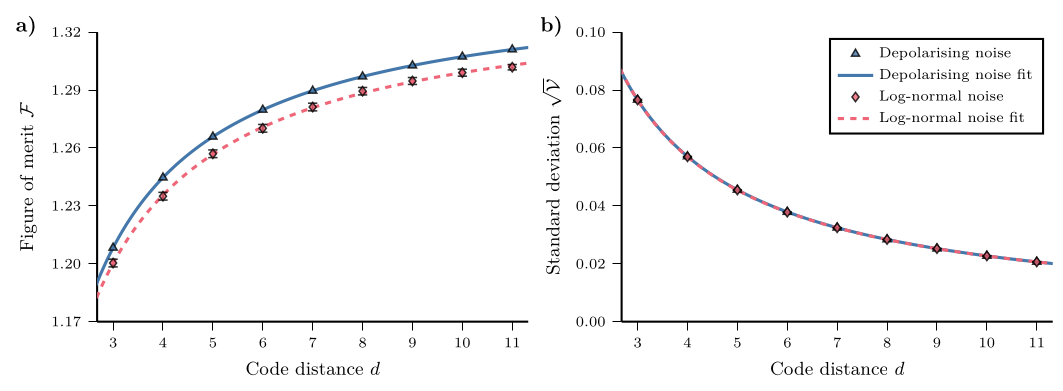

In [10]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising and lognormal noise
pad = 0.08
x_min = 3
x_int = 1
x_max = dist_max
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]), markersize=3, markeralpha=0.8,
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Code distance }d", xwiden=1 + pad,
    legend=:topright, legend_font_halign=:left)
# Figure of merit plot
y_min = 1.17
y_max = 1.32
y_int = 0.03
expectation_plot = scatter(dist_range, wls_expectation_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    markershape=:utriangle, color=colour_series[2], label="Depolarising noise",
    legend=false,
)
plot!(dense_range, wls_expectation_fit(dense_range);
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_expectation_scaling_log;
    yerror=2 * wls_sem_expectation_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, wls_expectation_fit_log(dense_range);
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
    extra_kwargs=:plot, add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (8.88,0.0) {\textbf{o}};
# Standard deviation plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_plot = scatter(dist_range, wls_stdev_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
    markershape=:utriangle,
    color=colour_series[2],
    label="Depolarising noise",
)
plot!(dense_range, sqrt.(wls_variance_fit(dense_range));
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_stdev_scaling_log;
    yerror=2 * wls_sem_stdev_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, sqrt.(wls_variance_fit_log(dense_range));
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
)
# Combined plot
combined_plot = plot(expectation_plot, stdev_plot; layout=(1, 2), size=(text_width_px * 0.991, col_height_px))
savefig(combined_plot, pwd() * "/figures/nrmse_scaling_$(rotated_param.circuit_name).pdf")
display(combined_plot)

#### Figure 5: Histogram of the figure of merit of the WLS design over random instances of log-normal Pauli noise as a function of code distance

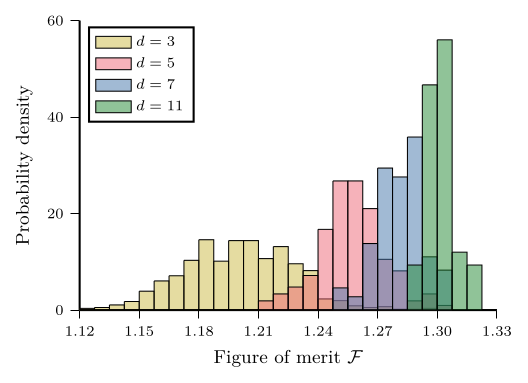

In [11]:
# Histogram of the figure of merit across instances of lognormal noise as a function of code distance
log_hist = histogram(
    wls_expectation_scaling_log[[1; 3; 5; 9]];
    labels=hcat([L"d = %$(d)" for d in dist_range[[1; 3; 5; 9]]]...),
    xlims=(1.12, 1.33), xticks=1.12:0.03:1.33, xwiden=1,
    xguide=L"\textrm{Figure of merit }\mathcal{F}",
    ylims=(0, 60), yticks=0:20:60,
    yguide="Probability density",
    bins=1.12:0.0075:1.33, normalize=:pdf,
    linewidth=0.5, legend=:topleft,
    size=(col_width_px, col_height_px),
)
plot_xlims = xlims(log_hist)
@assert plot_xlims[1] < minimum(minimum(wls_expectation_scaling_log)) && plot_xlims[2] > maximum(maximum(wls_expectation_scaling_log))
savefig(log_hist, pwd() * "/figures/nrmse_scaling_hist_$(rotated_param.circuit_name).pdf")
display(log_hist)

#### Confirming fit parameterisation with the corrected Akaike information criterion

In [12]:
# Compare the AICc of different fit parameterisations
wls_trace_data = DataFrame(y=wls_trace_scaling, x=dist_range)
wls_trace_constant_model = lm(@formula(y ~ 1), wls_trace_data)
wls_trace_linear_model = lm(@formula(y ~ 1 + x), wls_trace_data)
wls_trace_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_data)
wls_trace_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_data)
wls_trace_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_data)
wls_trace_aicc = [aicc(wls_trace_constant_model); aicc(wls_trace_linear_model); aicc(wls_trace_quadratic_model); aicc(wls_trace_cubic_model); aicc(wls_trace_quartic_model)]
wls_trace_sq_data = DataFrame(y=wls_trace_sq_scaling, x=dist_range)
wls_trace_sq_constant_model = lm(@formula(y ~ 1), wls_trace_sq_data)
wls_trace_sq_linear_model = lm(@formula(y ~ 1 + x), wls_trace_sq_data)
wls_trace_sq_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_sq_data)
wls_trace_sq_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_sq_data)
wls_trace_sq_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_sq_data)
wls_trace_sq_aicc = [aicc(wls_trace_sq_constant_model); aicc(wls_trace_sq_linear_model); aicc(wls_trace_sq_quadratic_model); aicc(wls_trace_sq_cubic_model); aicc(wls_trace_sq_quartic_model)]
# Print AICc
header = [
    "Model"
    "AICc"
]
model_types = ["Constant"; "Linear"; "Quadratic"; "Cubic"; "Quartic"]
println("The corrected Akaike information criteria of polynomial fits of tr(Σ) are:")
pretty_table(
    hcat(model_types, wls_trace_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:")
pretty_table(
    hcat(model_types, wls_trace_sq_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The quadratic model is best according to the AICc in both instances.")

The corrected Akaike information criteria of polynomial fits of tr(Σ) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 185.52  │
│ Linear    │ 158.64  │
│ Quadratic │ -177.84 │
│ Cubic     │ -173.76 │
│ Quartic   │ -160.42 │
└───────────┴─────────┘
The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 223.76  │
│ Linear    │ 197.53  │
│ Quadratic │ -128.75 │
│ Cubic     │ -124.58 │
│ Quartic   │ -111.11 │
└───────────┴─────────┘
The quadratic model is best according to the AICc in both instances.


#### Plotting and displaying various quantities as a function of code distance across the different designs

In [13]:
# Initialise data
plot_labels = [L"\mathrm{GLS}", L"\mathrm{WLS}", L"\mathrm{WLS}^*", L"\mathrm{OLS}"]
labels = ["GLS", "WLS", "WLS (misoptim.)", "OLS", "Basic (WLS)"]
marker_shapes = [:diamond, :utriangle, :dtriangle, :pentagon]
expectation_set = [gls_expectation_scaling, wls_expectation_scaling, wls_worst_expectation_scaling, ols_expectation_scaling, basic_expectation_scaling]
expectation_fit_set = [gls_expectation_fit, wls_expectation_fit, wls_worst_expectation_fit, ols_expectation_fit, basic_expectation_fit]
stdev_set = [gls_stdev_scaling, wls_stdev_scaling, wls_worst_stdev_scaling, ols_stdev_scaling, basic_stdev_scaling]
stdev_fit_set = [gls_variance_fit, wls_variance_fit, wls_worst_variance_fit, ols_variance_fit, basic_variance_fit]
experiment_number_set = [gls_experiment_number_scaling, wls_experiment_number_scaling, wls_worst_experiment_number_scaling, ols_experiment_number_scaling, basic_experiment_number_scaling]
cond_num_set = [gls_cond_num_scaling, wls_cond_num_scaling, wls_worst_cond_num_scaling, ols_cond_num_scaling, basic_cond_num_scaling]
pinv_norm_set = [gls_pinv_norm_scaling, wls_pinv_norm_scaling, wls_worst_pinv_norm_scaling, ols_pinv_norm_scaling, basic_pinv_norm_scaling];

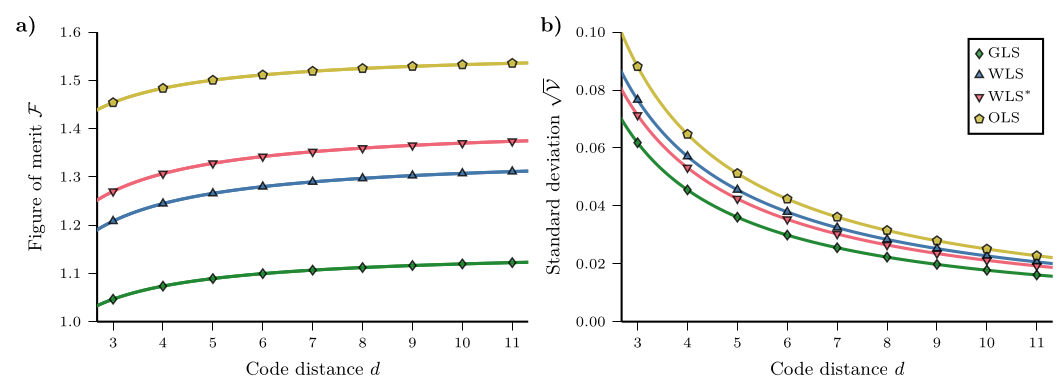

In [14]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising noise and a range of designs
# Figure of merit plot
y_min = 1.0
y_max = 1.6
y_int = 0.1
expectation_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    legend=false,
)
for idx in 1:4
    scatter!(dist_range, expectation_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
    )
    plot!(dense_range, expectation_fit_set[idx](dense_range);
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
    )
    if idx == 4
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
            extra_kwargs=:plot, add=raw"
            \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
            \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
            ")
        # \node at (0.0,0.0) {\textbf{o}};
        # \node at (8.88,0.0) {\textbf{o}};
    else
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
        )
    end
end
# Variance plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
)
for idx in 1:4
    scatter!(dist_range, stdev_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
        label=plot_labels[idx],
    )
    plot!(dense_range, sqrt.(stdev_fit_set[idx](dense_range));
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
        label=nothing,
    )
end
# Combined plot
combined_set_plot = plot(expectation_set_plot, stdev_set_plot; size=(text_width_px * 0.991, col_height_px))
savefig(combined_set_plot, pwd() * "/figures/nrmse_scaling_$(rotated_param.circuit_name)_combined.pdf")
display(combined_set_plot)

In [15]:
# Tables of the figure of merit and NRMSE standard deviation
println("The figures of merit for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; expectation_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; stdev_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)

The figures of merit for depolarising noise across a range of designs and code distances are:
┌────┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d  │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic (WLS) │
├────┼────────┼────────┼─────────────────┼────────┼─────────────┤
│ 3  │ 1.0465 │ 1.2083 │ 1.2700          │ 1.4539 │ 3.8148      │
│ 4  │ 1.0736 │ 1.2446 │ 1.3067          │ 1.4836 │ 3.8490      │
│ 5  │ 1.0893 │ 1.2658 │ 1.3281          │ 1.5004 │ 3.8684      │
│ 6  │ 1.0995 │ 1.2797 │ 1.3421          │ 1.5113 │ 3.8809      │
│ 7  │ 1.1067 │ 1.2896 │ 1.3521          │ 1.5190 │ 3.8897      │
│ 8  │ 1.1121 │ 1.2970 │ 1.3596          │ 1.5246 │ 3.8962      │
│ 9  │ 1.1163 │ 1.3027 │ 1.3653          │ 1.5290 │ 3.9012      │
│ 10 │ 1.1196 │ 1.3073 │ 1.3700          │ 1.5325 │ 3.9052      │
│ 11 │ 1.1223 │ 1.3110 │ 1.3737          │ 1.5354 │ 3.9084      │
└────┴────────┴────────┴─────────────────┴────────┴─────────────┘
The NRMSE standard deviations for depolarising n

In [16]:
# Table of experiment numbers
println("The experiment numbers across a range of designs and code distances are:")
pretty_table(hcat([[dist_range]; experiment_number_set]...); header=["d"; labels], alignment=:l)
println("Almost all of these values are constant with code distance, and they saturate at distance 8.")

The experiment numbers across a range of designs and code distances are:
┌────┬──────┬──────┬─────────────────┬─────┬─────────────┐
│ d  │ GLS  │ WLS  │ WLS (misoptim.) │ OLS │ Basic (WLS) │
├────┼──────┼──────┼─────────────────┼─────┼─────────────┤
│ 3  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 4  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 5  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 6  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 7  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 8  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 9  │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 10 │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
│ 11 │ 1026 │ 1026 │ 1170            │ 774 │ 168         │
└────┴──────┴──────┴─────────────────┴─────┴─────────────┘
Almost all of these values are constant with code distance, and they saturate at distance 8.


In [17]:
# Table of condition numbers and pseudoinverse norms
println("The design matrix condition numbers across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; cond_num_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.2f"))
)
println("The design matrix pseudoinverse norms across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; pinv_norm_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("""
The condition numbers and pseudoinverse norms do not substantially change with code distance.
The basic design has the best condition number despite performing by far the worst.
The optimised WLS design has a worse pseudoinverse norm than the worst-performing WLS design optimised for different noise parameters.""")

The design matrix condition numbers across a range of designs and code distances are:
┌────┬────────┬────────┬─────────────────┬───────┬─────────────┐
│ d  │ GLS    │ WLS    │ WLS (misoptim.) │ OLS   │ Basic (WLS) │
├────┼────────┼────────┼─────────────────┼───────┼─────────────┤
│ 3  │ 187.98 │ 181.75 │ 380.56          │ 97.57 │ 29.39       │
│ 4  │ 191.85 │ 185.86 │ 387.92          │ 98.01 │ 30.97       │
│ 5  │ 193.86 │ 188.13 │ 391.98          │ 98.23 │ 31.70       │
│ 6  │ 195.17 │ 189.59 │ 394.67          │ 98.35 │ 32.09       │
│ 7  │ 196.13 │ 190.63 │ 396.61          │ 98.43 │ 32.33       │
│ 8  │ 196.85 │ 191.39 │ 398.07          │ 98.49 │ 32.48       │
│ 9  │ 197.40 │ 191.96 │ 399.19          │ 98.53 │ 32.59       │
│ 10 │ 197.83 │ 192.41 │ 400.07          │ 98.55 │ 32.66       │
│ 11 │ 198.18 │ 192.77 │ 400.77          │ 98.57 │ 32.71       │
└────┴────────┴────────┴─────────────────┴───────┴─────────────┘
The design matrix pseudoinverse norms across a range of designs and c